In [1]:
import os
from scipy import io

all_faces = io.loadmat(os.path.join("..", "DATA", "allFaces.mat"))
print(all_faces.keys())

dict_keys(['__header__', '__version__', '__globals__', 'faces', 'n', 'm', 'sub', 'nfaces', 'person'])


In [283]:
faces = all_faces["faces"]
nfaces = all_faces["nfaces"].flatten().astype(int)
n = all_faces["n"][0][0].astype(int)
m = all_faces["m"][0][0].astype(int)
print(faces.shape)
print(n * m)

(32256, 2410)
32256


(4, 10)


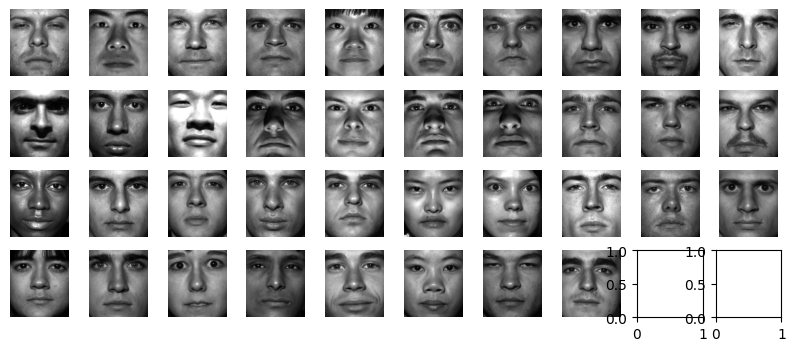

In [314]:
from matplotlib import pyplot as plt
import numpy as np

fig, axs = plt.subplots(4, 10, figsize=(10, 4))
print(axs.shape)
cum_sum_faces = np.cumsum(nfaces) - 58

index = 0
for i, ax_row in enumerate(axs):
    for j, ax in enumerate(ax_row):
        if index == len(cum_sum_faces):
            break

        ax.imshow(faces[:, cum_sum_faces[index]].reshape(m, n).T, cmap="gray")
        index += 1
        ax.axis("off")

In [364]:
sex = np.array([0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0])
nsex = np.concatenate([np.repeat(sex[i], nfaces[i]) for i in range(len(nfaces))])

In [11]:
from skimage.transform import resize
import numpy as np

cropped_faces = np.array([resize(faces[:, i].reshape(m, n), (32, 32)).reshape(-1) for i in range(faces.shape[1])]).T

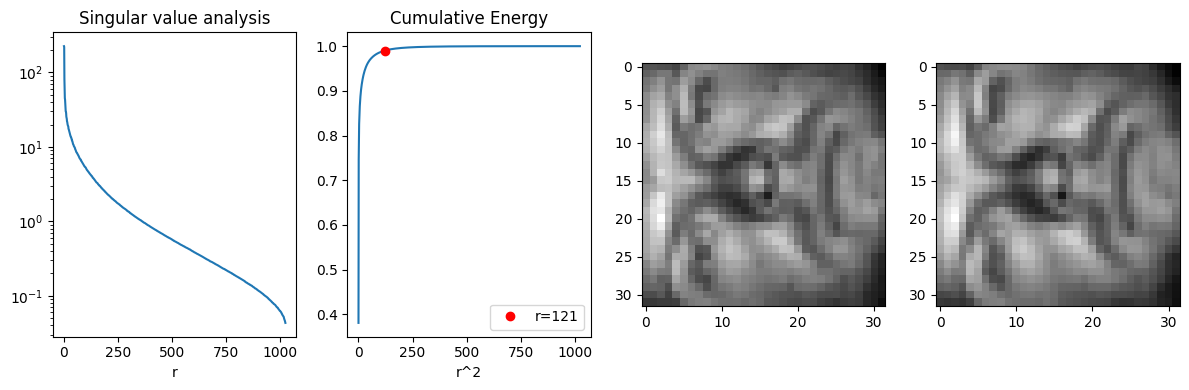

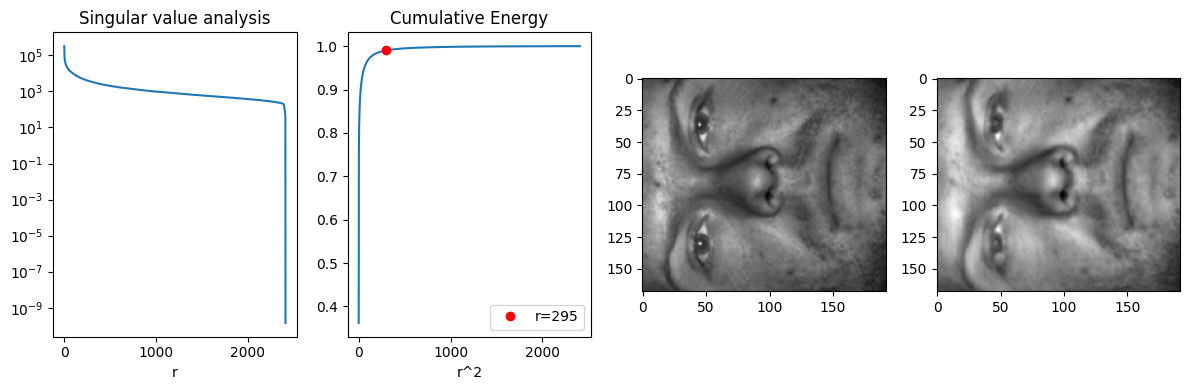

In [234]:
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

def svd_analysis(data, m, n):
    U, S, VT = np.linalg.svd(data, full_matrices=False)

    fig, axs = plt.subplots(1, 4, figsize=(12, 4))

    axs[0].semilogy(S)
    axs[0].set_title("Singular values")
    axs[0].set_xlabel("r")

    explained_variance_ratio = S**2 / np.sum(S ** 2)
    cum_explained_variance_ratio = np.cumsum(explained_variance_ratio)
    axs[1].plot(cum_explained_variance_ratio)
    axs[1].set_title("Cumulative Energy")
    axs[1].set_xlabel("r^2")

    num_modes = np.searchsorted(cum_explained_variance_ratio, 0.99)
    axs[1].plot(num_modes, cum_explained_variance_ratio[num_modes], "ro", label=f"r={num_modes}")
    axs[1].legend()

    reconstructed_data = U[:, :num_modes] @ np.diag(S[:num_modes]) @ VT[:num_modes, :]

    axs[2].imshow(data[0].reshape(m, n), cmap="grey")
    axs[3].imshow(reconstructed_data[0].reshape(m, n), cmap="grey")
    fig.tight_layout()

scaler = StandardScaler(with_std=False)

# Subtract the mean to match the behavior of the PCA class
svd_analysis(scaler.fit_transform(cropped_faces.T), 32, 32)
svd_analysis(scaler.fit_transform(faces.T), m, n)

In [259]:
from sklearn.decomposition import PCA

# Sanity check
pca = PCA()
projected_cropped_faces = pca.fit_transform(cropped_faces.T)
num_modes = np.searchsorted(np.cumsum(pca.explained_variance_ratio_), 0.99)
print(num_modes)

121


In [280]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

def run_classifier_pipeline(classifier, param_grid, X_train, y_train):
    pca = PCA()
    pipeline = make_pipeline(StandardScaler(), pca, classifier)
    grid = GridSearchCV(pipeline, param_grid, refit=True, verbose=2, cv=5, n_jobs=-1)
    grid.fit(X_train, y_train)
    return grid

# Create labels
y = np.concatenate([np.full(nfaces[i], i) for i in range(len(nfaces))])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(cropped_faces.T, y, test_size=0.2, random_state=42)

# Define parameters for each classifier
classifiers = {
    'SVC': (SVC(), {
        'pca__n_components': [10, 20, 30, 40, 50, 60, 120],
        'svc__C': [0.1, 1, 10, 100],
        'svc__gamma': [1, 0.1, 0.01, 0.001],
        'svc__kernel': ['rbf', 'linear']
    }),
    'LinearDiscriminantAnalysis': (LinearDiscriminantAnalysis(), {
        'pca__n_components': [10, 20, 30, 40, 50, 60, 120],
        'lineardiscriminantanalysis__solver': ['svd', 'lsqr', 'eigen']
    }),
    'DecisionTreeClassifier': (DecisionTreeClassifier(random_state=42), {
        'pca__n_components': [10, 20, 30, 40, 50, 60, 120],
        'decisiontreeclassifier__max_depth': [None, 10, 20, 30, 40, 50],
        'decisiontreeclassifier__min_samples_split': [2, 5, 10],
        'decisiontreeclassifier__min_samples_leaf': [1, 2, 4]
    })
}

# Run each classifier pipeline and store the grids
grids = {}
for classifier_name, (classifier, param_grid) in classifiers.items():
    grids[classifier_name] = run_classifier_pipeline(classifier, param_grid, X_train, y_train)



Fitting 5 folds for each of 224 candidates, totalling 1120 fits
[CV] END pca__n_components=10, svc__C=0.1, svc__gamma=1, svc__kernel=rbf; total time=   0.6s
[CV] END pca__n_components=10, svc__C=0.1, svc__gamma=1, svc__kernel=rbf; total time=   0.6s
[CV] END pca__n_components=10, svc__C=0.1, svc__gamma=1, svc__kernel=rbf; total time=   0.5s
[CV] END pca__n_components=10, svc__C=0.1, svc__gamma=1, svc__kernel=rbf; total time=   0.6s
[CV] END pca__n_components=10, svc__C=0.1, svc__gamma=1, svc__kernel=rbf; total time=   0.6s
[CV] END pca__n_components=10, svc__C=0.1, svc__gamma=1, svc__kernel=linear; total time=   0.6s
[CV] END pca__n_components=10, svc__C=0.1, svc__gamma=1, svc__kernel=linear; total time=   0.6s
[CV] END pca__n_components=10, svc__C=0.1, svc__gamma=1, svc__kernel=linear; total time=   0.6s
[CV] END pca__n_components=10, svc__C=0.1, svc__gamma=0.1, svc__kernel=rbf; total time=   0.4s
[CV] END pca__n_components=10, svc__C=0.1, svc__gamma=0.1, svc__kernel=rbf; total time= 

In [281]:
# Print results for each classifier
for classifier_name, grid in grids.items():
    print(f"{classifier_name} Best parameters: {grid.best_params_}")
    print(f"{classifier_name} Test set score: {grid.score(X_test, y_test)}")
    y_pred = grid.predict(X_test)
    print(f"{classifier_name} Classification report:\n{classification_report(y_test, y_pred)}")
    print("\n")

SVC Best parameters: {'pca__n_components': 120, 'svc__C': 0.1, 'svc__gamma': 0.001, 'svc__kernel': 'linear'}
SVC Test set score: 0.9543568464730291
SVC Classification report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.83      0.91        12
           2       0.81      1.00      0.90        13
           3       0.87      1.00      0.93        20
           4       1.00      1.00      1.00        13
           5       0.91      1.00      0.95        10
           6       1.00      0.89      0.94        18
           7       1.00      1.00      1.00        17
           8       1.00      0.92      0.96        12
           9       1.00      0.77      0.87        13
          10       1.00      0.92      0.96        13
          11       1.00      1.00      1.00         4
          12       1.00      0.93      0.96        14
          13       1.00      1.00      1.00        14
          14  

In [324]:
# Run each classifier pipeline and store the grids
X_train_sex, X_test_sex, y_train_sex, y_test_sex = train_test_split(cropped_faces.T, nsex, test_size=0.2, random_state=42)

grids_sex = {}
for classifier_name, (classifier, param_grid) in classifiers.items():
    grids_sex[classifier_name] = run_classifier_pipeline(classifier, param_grid, X_train_sex, y_train_sex)

Fitting 5 folds for each of 224 candidates, totalling 1120 fits
[CV] END pca__n_components=10, svc__C=0.1, svc__gamma=1, svc__kernel=rbf; total time=   0.2s
[CV] END pca__n_components=10, svc__C=0.1, svc__gamma=1, svc__kernel=linear; total time=   0.3s
[CV] END pca__n_components=10, svc__C=0.1, svc__gamma=1, svc__kernel=linear; total time=   0.2s
[CV] END pca__n_components=10, svc__C=0.1, svc__gamma=1, svc__kernel=rbf; total time=   0.3s
[CV] END pca__n_components=10, svc__C=0.1, svc__gamma=1, svc__kernel=rbf; total time=   0.3s
[CV] END pca__n_components=10, svc__C=0.1, svc__gamma=1, svc__kernel=rbf; total time=   0.3s
[CV] END pca__n_components=10, svc__C=0.1, svc__gamma=1, svc__kernel=rbf; total time=   0.3s
[CV] END pca__n_components=10, svc__C=0.1, svc__gamma=1, svc__kernel=linear; total time=   0.2s
[CV] END pca__n_components=10, svc__C=0.1, svc__gamma=1, svc__kernel=linear; total time=   0.2s
[CV] END pca__n_components=10, svc__C=0.1, svc__gamma=0.1, svc__kernel=linear; total ti

In [365]:
# Print results for each classifier
for classifier_name, grid in grids_sex.items():
    print(f"{classifier_name} Best parameters: {grid.best_params_}")
    print(f"{classifier_name} Test set score: {grid.score(X_test_sex, y_test_sex)}")
    y_pred = grid.predict(X_test_sex)
    print(f"{classifier_name} Classification report:\n{classification_report(y_test_sex, y_pred)}")
    print("\n")

SVC Best parameters: {'pca__n_components': 120, 'svc__C': 100, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
SVC Test set score: 0.9854771784232366
SVC Classification report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       392
           1       0.97      0.96      0.96        90

    accuracy                           0.99       482
   macro avg       0.98      0.97      0.98       482
weighted avg       0.99      0.99      0.99       482



LinearDiscriminantAnalysis Best parameters: {'lineardiscriminantanalysis__solver': 'eigen', 'pca__n_components': 120}
LinearDiscriminantAnalysis Test set score: 0.9605809128630706
LinearDiscriminantAnalysis Classification report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       392
           1       0.96      0.82      0.89        90

    accuracy                           0.96       482
   macro avg       0.96      0.91      0.93       4

In [460]:
X = PCA(n_components=120).fit_transform(cropped_faces.T)
print(X.shape)

(2410, 120)


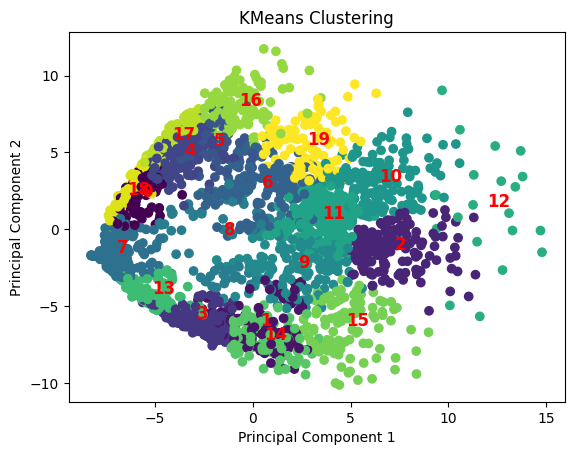

In [609]:
from sklearn.cluster import KMeans

n_clusters_kmeans = 20
# Fit KMeans
kmeans = KMeans(n_clusters=n_clusters_kmeans, random_state=42)
y_labels_kmeans = kmeans.fit_predict(X)

# Plot the data points and color them based on the cluster label
plt.scatter(X[:, 0], X[:, 1], c=y_labels_kmeans, cmap='viridis')

# Plot the centroids
centroids = kmeans.cluster_centers_

# Annotate the centroids with cluster numbers
for i, centroid in enumerate(centroids):
    plt.text(centroid[0], centroid[1], str(i), color='red', fontsize=12, weight='bold')

# Labeling the plot
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans Clustering')
plt.show()

56 unique classes
1721 unclassified points


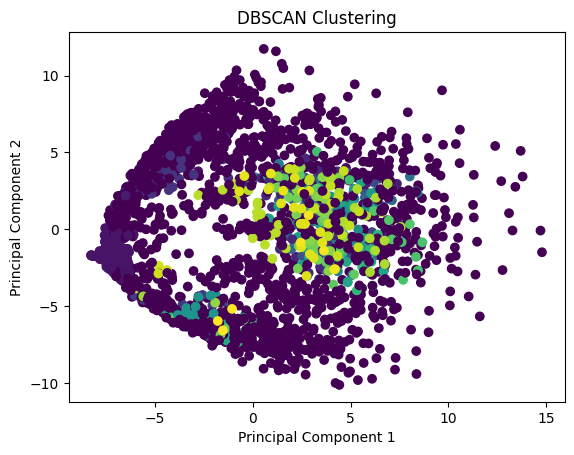

In [610]:
from sklearn.cluster import DBSCAN

DBSCAN_model = DBSCAN(eps=2, min_samples=3)
y_labels_DBSCAN = DBSCAN_model.fit_predict(X)
n_clusters_DBSCAN = len(np.unique(y_labels_DBSCAN)) - 1
print(f"{n_clusters_DBSCAN} unique classes")
print(f"{list(y_labels_DBSCAN).count(-1)} unclassified points")

plt.scatter(X[:, 0], X[:, 1], c=y_labels_DBSCAN, cmap='viridis')

# Labeling the plot
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('DBSCAN Clustering')
plt.show()

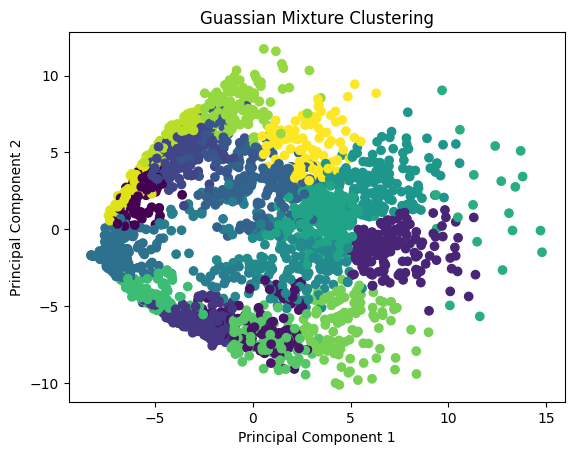

In [611]:
from sklearn.mixture import GaussianMixture

n_clusters_guassian_mixture = 20
guassian_mixture = GaussianMixture(n_components=n_clusters_guassian_mixture, random_state=42)
y_labels_guassian = guassian_mixture.fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_labels_kmeans, cmap='viridis')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Guassian Mixture Clustering')
plt.show()

In [612]:
np.random.seed(42)
def plot_clusters(n_clusters, y_labels):
    for i in range(n_clusters):
        fig, axs = plt.subplots(1, 10, figsize=(10, 4))

        for j, ax in enumerate(axs):
            cluster_indices = np.nonzero(y_labels == i)[0]
            ax.imshow(cropped_faces[:, y_labels == i][:, np.random.randint(len(cluster_indices))].reshape(32, 32).T, cmap="gray")
            ax.axis("off")
            if j == 0:
                ax.set_title(f"Cluster {i} from {np.sum(y_labels == i)} points")

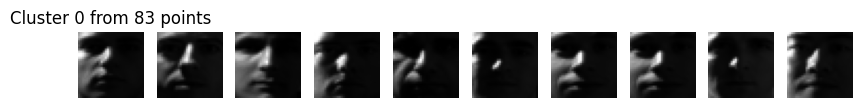

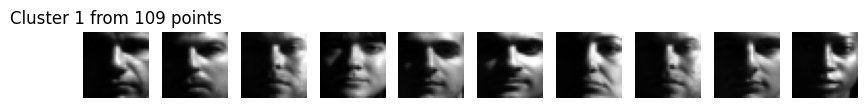

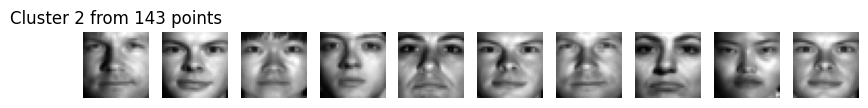

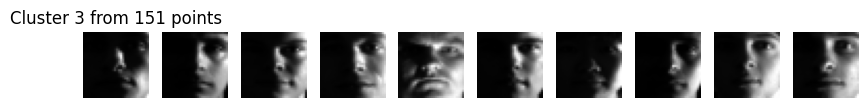

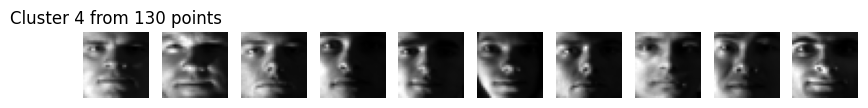

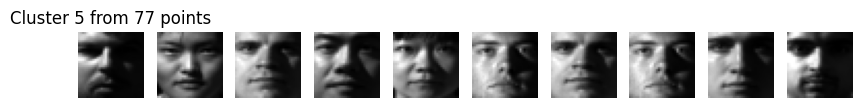

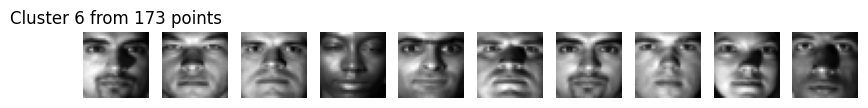

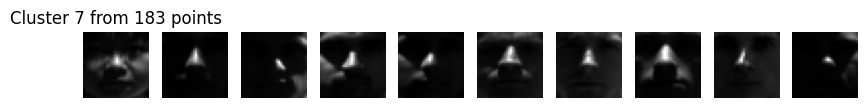

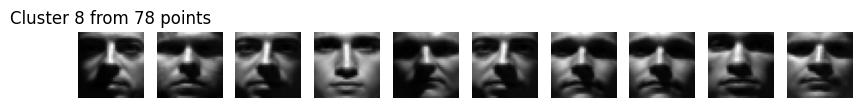

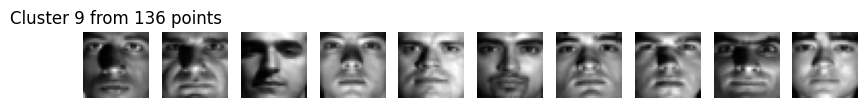

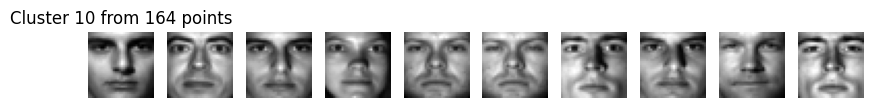

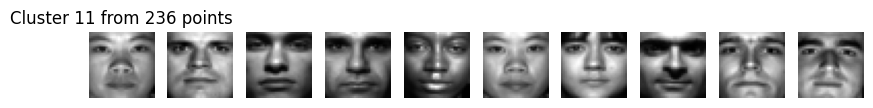

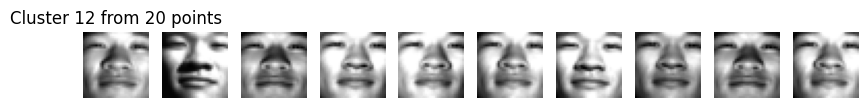

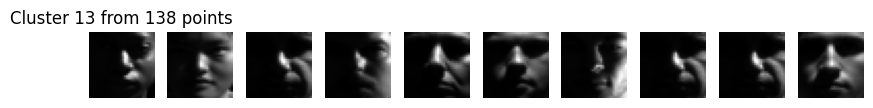

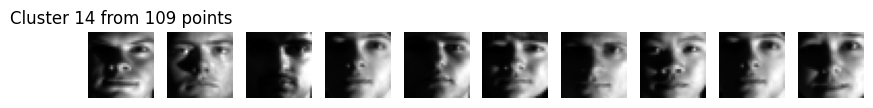

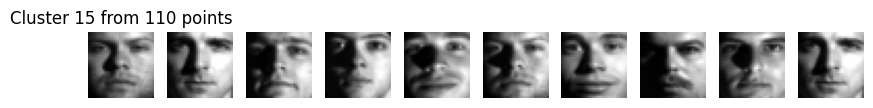

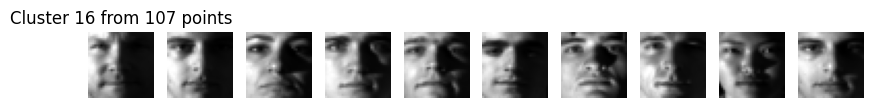

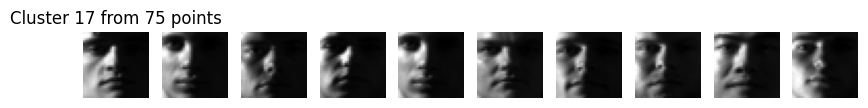

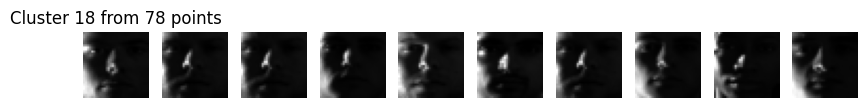

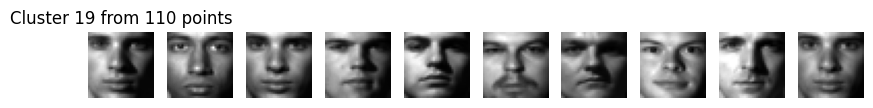

In [613]:
plot_clusters(n_clusters_kmeans, y_labels_kmeans)

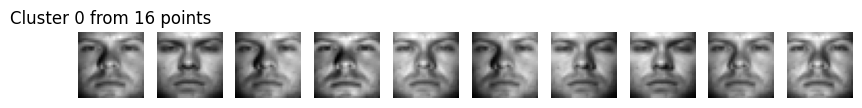

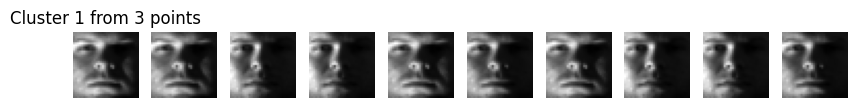

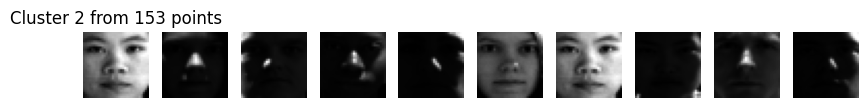

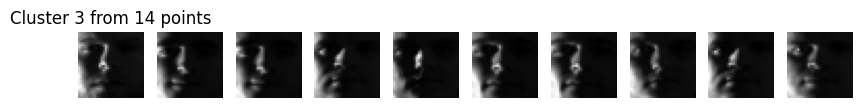

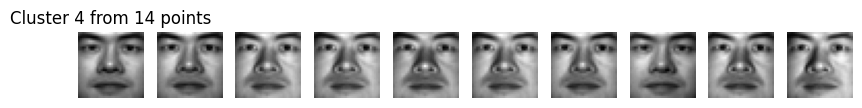

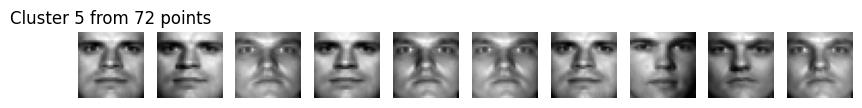

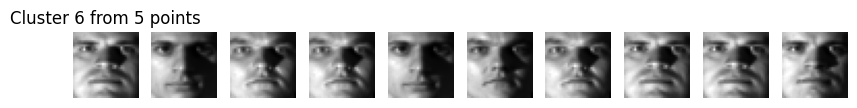

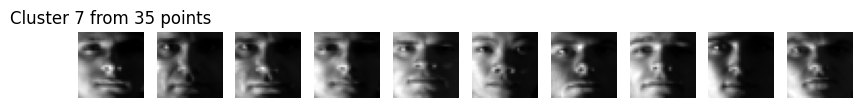

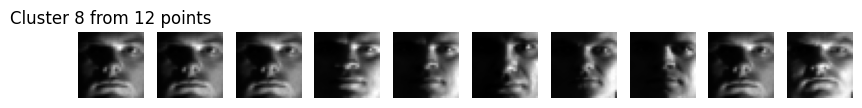

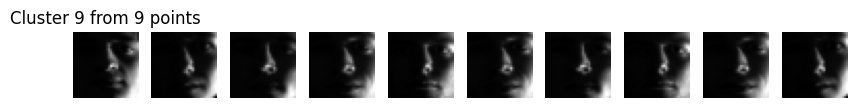

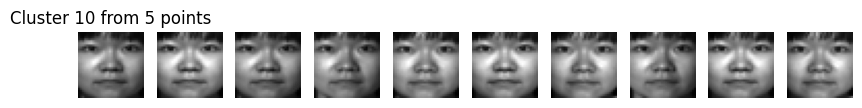

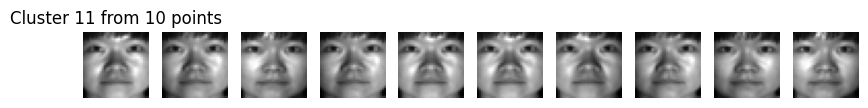

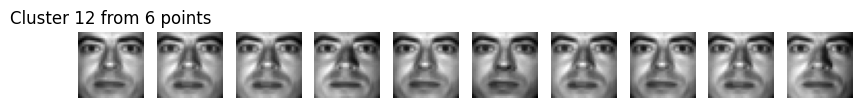

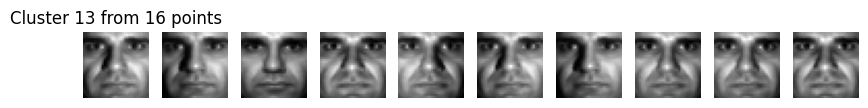

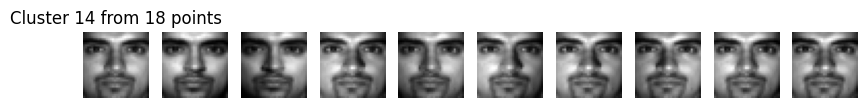

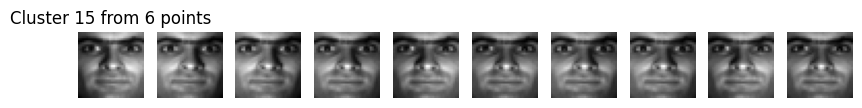

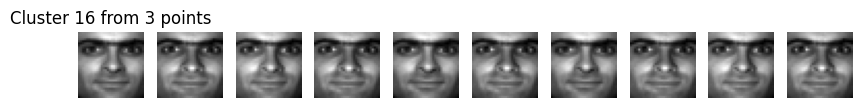

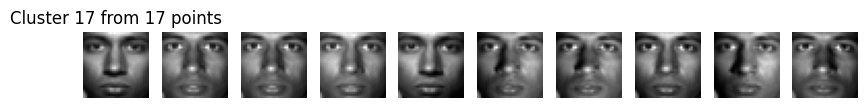

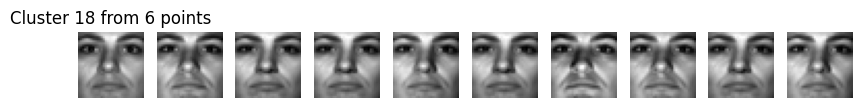

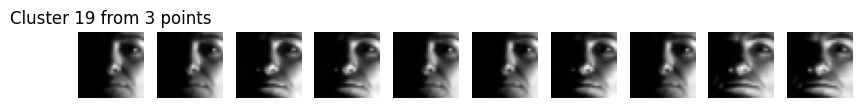

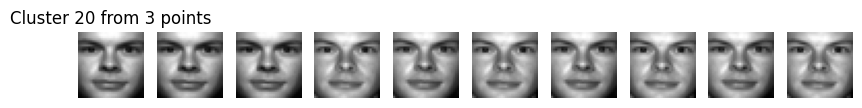

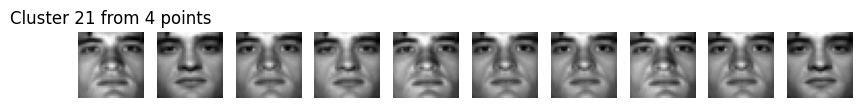

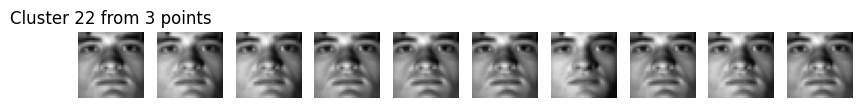

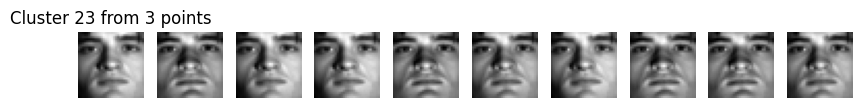

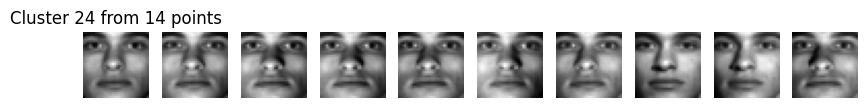

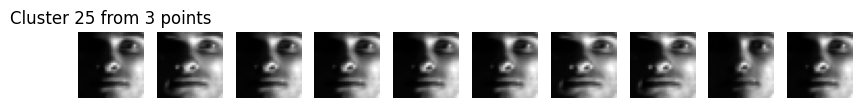

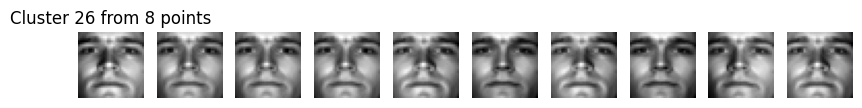

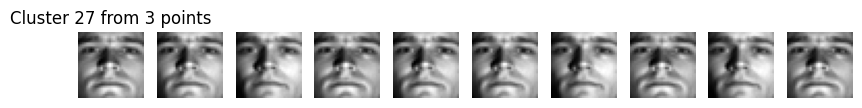

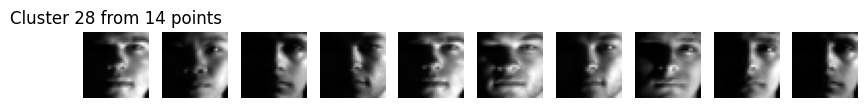

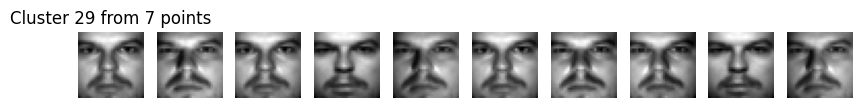

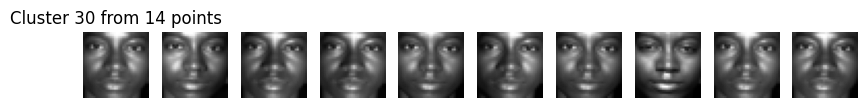

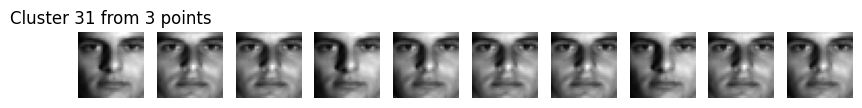

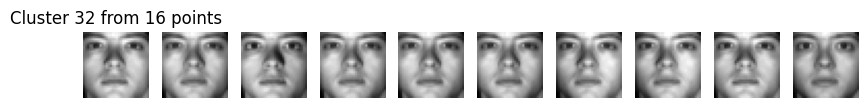

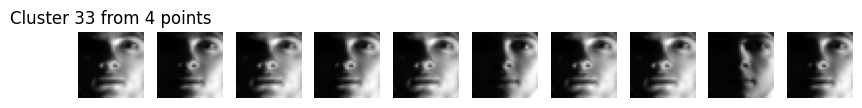

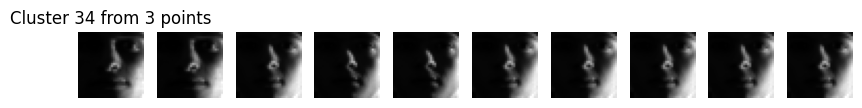

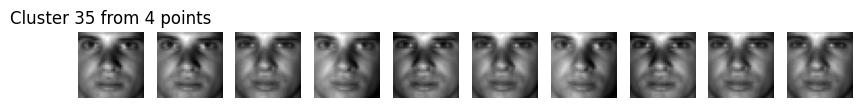

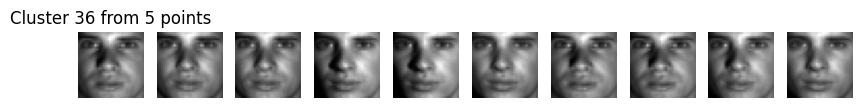

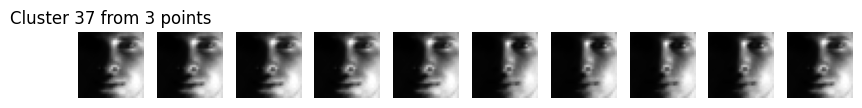

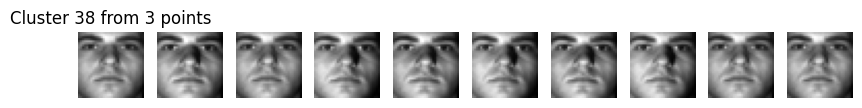

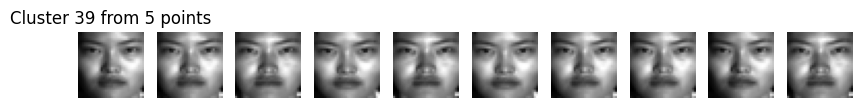

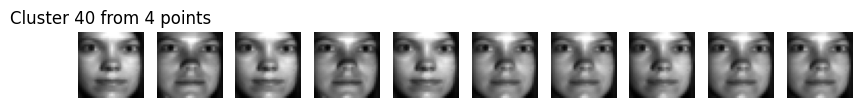

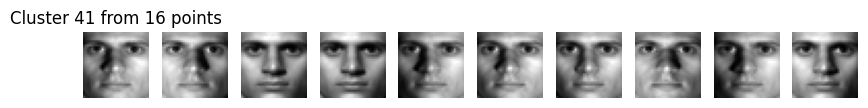

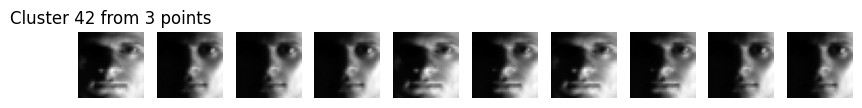

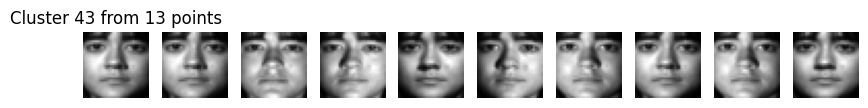

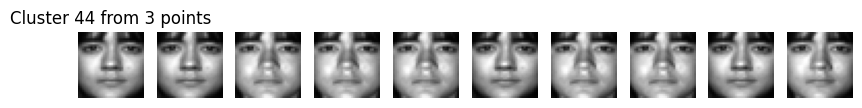

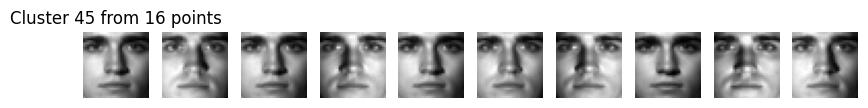

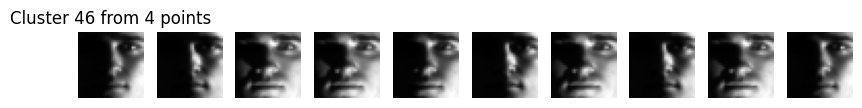

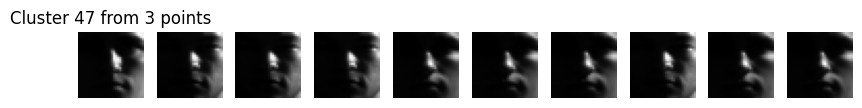

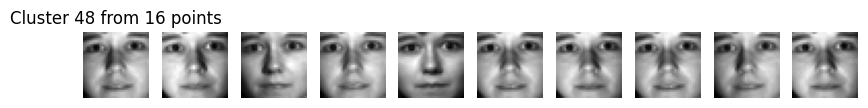

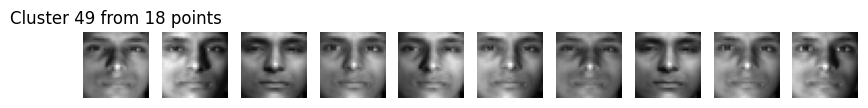

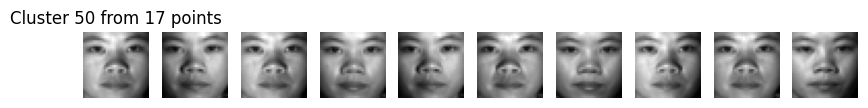

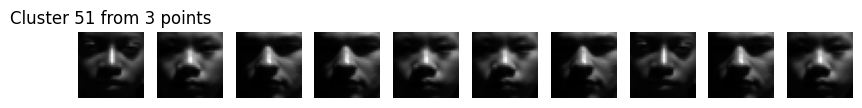

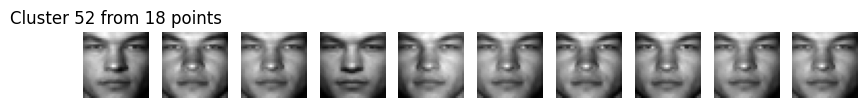

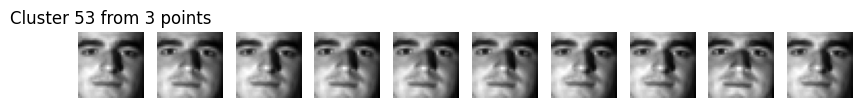

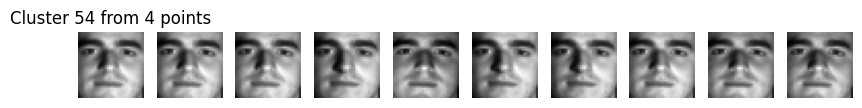

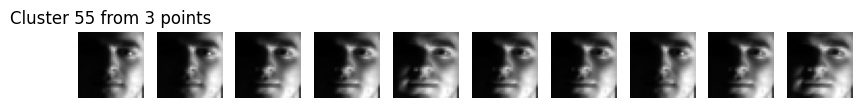

In [615]:
plot_clusters(n_clusters_DBSCAN, y_labels_DBSCAN)

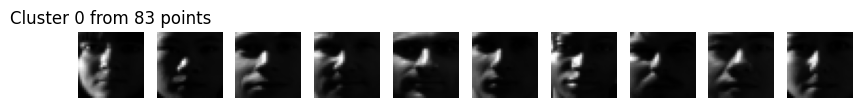

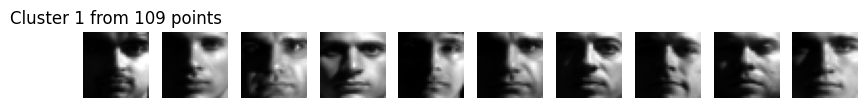

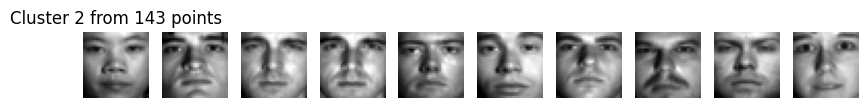

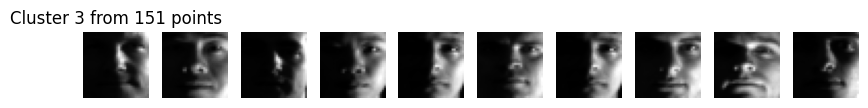

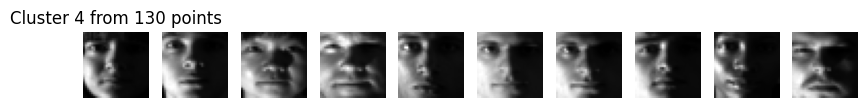

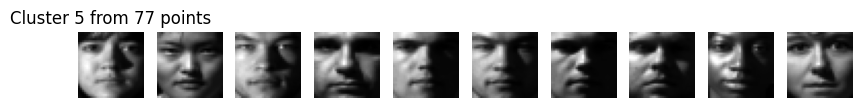

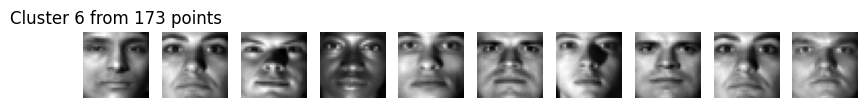

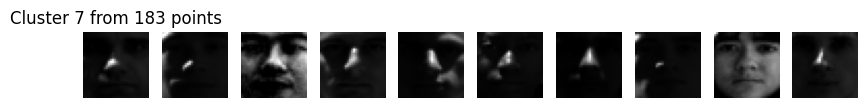

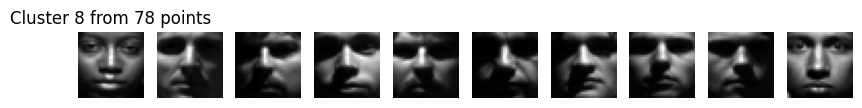

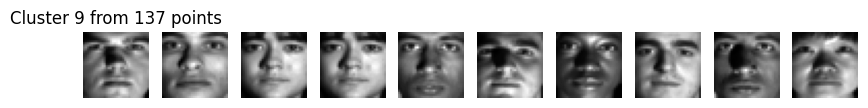

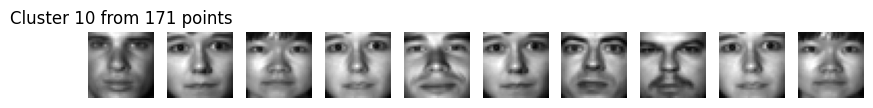

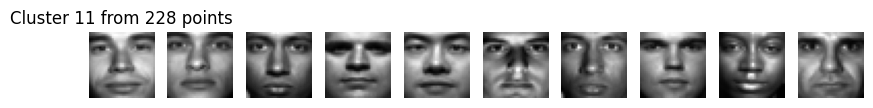

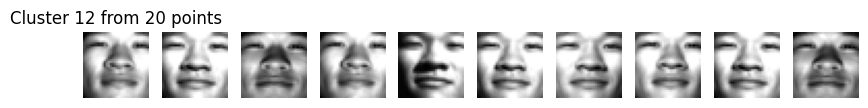

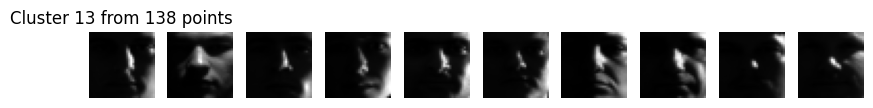

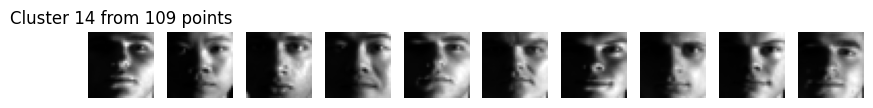

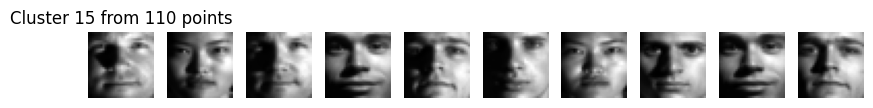

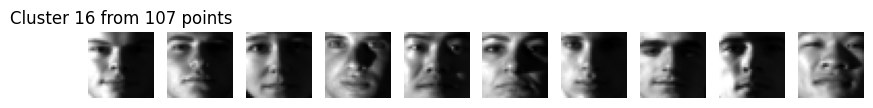

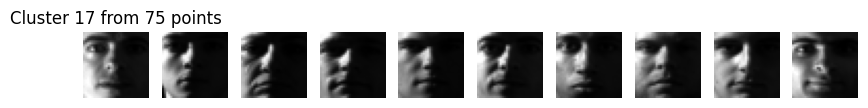

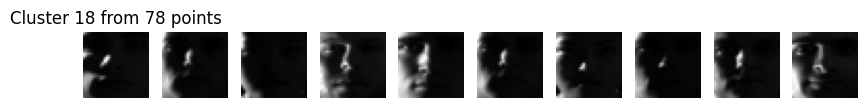

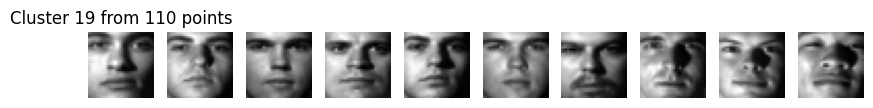

In [616]:
plot_clusters(n_clusters_guassian_mixture, y_labels_guassian)